# 유튜브 랭링 사이크 크롤링 과제
- 카테고리, 제목, 구독자 등 최대 200개 이상 크롤링
- 카테고리별 분석하여 그래프(파이등)로 시각화 

In [2]:
# Jupyter Notebook 설정 : 모든 결과 출력
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity="all"

In [ ]:
!pip install selenium

In [ ]:
!pip install webdriver_manager

In [81]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service as ChromeService
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import time

# plt.show() 동작 방법 변경 (window >> jupyter notebook)
%matplotlib inline 

In [50]:
from matplotlib import font_manager, rc
import matplotlib as mpl
import platform

mpl.rcParams['axes.unicode_minus'] = False

system = platform.system()
if system == "Windows":
    font_path = "C:/Windows/Fonts/malgun.ttf"
elif system == "Darwin": # Mac OS
    font_path = "/System/Library/Fonts/AppleSDGothicNeo.ttc"
elif system == "Linux":
    font_path = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"
else:
    font_path = None

if font_path:
    font = font_manager.FontProperties(fname=font_path).get_name()
    mpl.rcParams['font.family'] = font
else:
    print("폰트 경로를 확인해주세요.")

## 유튜브 랭링 사이크 크롤링

In [47]:
def to_int(number_str):
    int_value = 0
    number_str = number_str.strip().replace(",", "").replace("개", "")
    find_index = number_str.find("억") 
    if (find_index > -1):
        num_str_list = number_str.split("억")
        int_value += int(num_str_list[0]) * 100000000
        number_str = num_str_list[1]
    find_index = number_str.find("만")
    if (find_index > -1):
        num_str_list = number_str.split("만")
        int_value += int(num_str_list[0]) * 10000
        number_str = num_str_list[1]
    if (bool(number_str)):
        int_value += int(number_str)
    return int_value

df = pd.DataFrame(columns=["rank", "category1", "category2", "category3", "channel", "title", "subscriber", "view", "video"])
url = "https://youtube-rank.com/board/bbs/board.php?bo_table=youtube&page="
driver = webdriver.Chrome(service=ChromeService(ChromeDriverManager().install())) # 웹드라이버 객체 생성

try:
    index = 0
    pages = 3 # 페이지수 (페이지당 100개)
    for i in range(pages):
        driver.get("{0}{1}".format(url, i+1)) # 페이지 이동
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);") # 화면 하단으로 스크롤
        tr_tags = driver.find_elements(By.CSS_SELECTOR, "tr.aos-init.aos-animate") # list
        #print(len(td_tags))
        for tr_tag in tr_tags:
            row_list = []
            # rank
            rank_tags = tr_tag.find_elements(By.CSS_SELECTOR, "td.rank")
            if (len(rank_tags) == 0) or (not bool(rank_tags[0].text)):
                raise Exception("Rank not found")
            row_list.append(int(rank_tags[0].text))
            # category
            category_tags = tr_tag.find_elements(By.CSS_SELECTOR, "p.category") # list
            if (len(category_tags) == 0) or (not bool(category_tags[0].text)):
                raise Exception("Category not found")
            category_str = category_tags[0].text
            if (category_str[0] != "[") or (category_str[-1] != "]"):
                raise Exception("Category format error")
            category_str = category_str[1:-1]
            category_list = category_str.split("/")
            if (len(category_list) == 3):
                row_list.append(category_list[0])
                row_list.append(category_list[1])
                row_list.append(category_list[2])
            elif (len(category_list) == 2):
                row_list.append(category_list[0])
                row_list.append(category_list[1])
                row_list.append(np.nan)
            elif (len(category_list) == 1):
                row_list.append(category_list[0])
                row_list.append(np.nan)
                row_list.append(np.nan)
            else:
                raise Exception("Category format error! (%s)" % category_str)
            # channel
            channel_tags = tr_tag.find_elements(By.CSS_SELECTOR, "td.subject > h1 > a")
            if (len(channel_tags) == 0) or (not bool(channel_tags[0].text)):
                raise Exception("Channel not found")
            row_list.append(channel_tags[0].text)
            # title
            title_tags = tr_tag.find_elements(By.CSS_SELECTOR, "td.subject > h2 > span > a")
            row_list.append(title_tags[0].text if (len(title_tags) > 0) else np.nan)
            # subscriber
            subscriber_tags = tr_tag.find_elements(By.CSS_SELECTOR, "td.subscriber_cnt")
            row_list.append(to_int(subscriber_tags[0].text) if (len(subscriber_tags) > 0) else 0)
            # view
            view_tags = tr_tag.find_elements(By.CSS_SELECTOR, "td.view_cnt")
            row_list.append(to_int(view_tags[0].text) if (len(view_tags) > 0) else 0)
            # video
            video_tags = tr_tag.find_elements(By.CSS_SELECTOR, "td.video_cnt")
            row_list.append(to_int(video_tags[0].text) if (len(video_tags) > 0) else 0)
            # row 추가
            df.loc[index] = row_list
            index += 1
except Exception as e:
    driver.execute_script("alert('%s');" % e) # alert 생성
    print(e)

df.to_excel("youtube_ranking.xlsx", index=False)
driver.quit()
df

,rank,category1,category2,category3,channel,title,subscriber,view,video
0,1,BJ,인물,연예인,김프로KIMPRO,김프로 kimpro 김동준 김프로유투브 틱톡김프로 유투브김프로 김동준유튜브 유백합 ...,126000000,121896750000,3690
1,2,음악,댄스,가수,BLACKPINK,"""YG Entertainment"" YG 와이지 K-pop BLACKPINK 블랙핑크...",99400000,40772800000,641
2,3,음악,댄스,가수,BANGTANTV,BTS 방탄 방탄소년단 빅히트 BANGTAN RM Jin SUGA j-hope Ji...,81800000,26052130000,2947
3,4,음악,댄스,가수,HYBE LABELS,NaN,79200000,42682130000,2933
4,5,미분류,NaN,NaN,Justin Bieber,Justin Bieber kidrauhl one time biebs usher is...,76600000,36670360000,278
...,...,...,...,...,...,...,...,...,...
295,293,주식,경제,부동산,삼프로TV 3PROTV,경제 주식 투자 부자 돈 금융 삼프로 삼프로TV 정영진 이진우 김동환 부동산 재테크...,2830000,1580450000,19517
296,297,미분류,NaN,NaN,뜬뜬 DdeunDdeun,뜬뜬 ddeunddeun 안테나플러스 스튜디오 유재석 핑계고 유튜브 뜬뜬채널 채널뜬...,2820000,843510000,379
297,298,BJ,인물,연예인,진용진,다큐멘터리 코미디 kdrama kmovie drama 드라마 리뷰 영화 웹드라마 k...,2810000,1305380000,747
298,299,IT,기술,컴퓨터,ITSub잇섭,it 전자제품 리뷰 일상 전자기기 스마트폰 컴퓨터 게이밍 테크 Tech,2790000,1361310000,1460


## 카테고리별 분석 및 시각화

### 데이터 확인
- category2, category3, title 컬럼에 NaN 값이 존재
- 분석은 category1 컬럼으로 처리

In [58]:
df.count()

rank          300
category1     300
category2     240
category3     133
channel       300
title         240
subscriber    300
view          300
video         300
dtype: int64

### 파이 차트

<Figure size 1500x1500 with 0 Axes>

([<matplotlib.patches.Wedge at 0x192a548bd90>,
 [Text(0.8830991954152857, 0.6558473992148443, 'BJ'),
  Text(-0.3068901326118301, 1.0563230786579896, '음악'),
  Text(-1.0709367715883138, 0.2511860490950886, '미분류'),
  Text(-0.934881964848125, -0.5796513709133355, '해외'),
  Text(-0.4474103071135548, -1.004900003526995, '영화'),
  Text(0.0805618883044894, -1.0970459343859833, 'TV'),
  Text(0.46835788548312296, -0.9953094448993128, '키즈'),
  Text(0.7011666374145077, -0.8475643613182615, '음식'),
  Text(0.8326947069197713, -0.7187624955907176, '게임'),
  Text(0.9348818404729939, -0.5796515715098405, '스포츠'),
  Text(1.0095300919694352, -0.43686267110864957, '회사'),
  Text(1.059478795377807, -0.29581190331829266, '뉴스'),
  Text(1.0845956020179086, -0.18344585054835827, '패션'),
  Text(1.0939740087258842, -0.11498203438893809, '취미'),
  Text(1.0970458726024364, -0.08056272963324489, '애완'),
  Text(1.0984924604662631, -0.05757008162905176, '교육'),
  Text(1.0994572055257903, -0.034552181080508775, '주식'),
  Text(1.

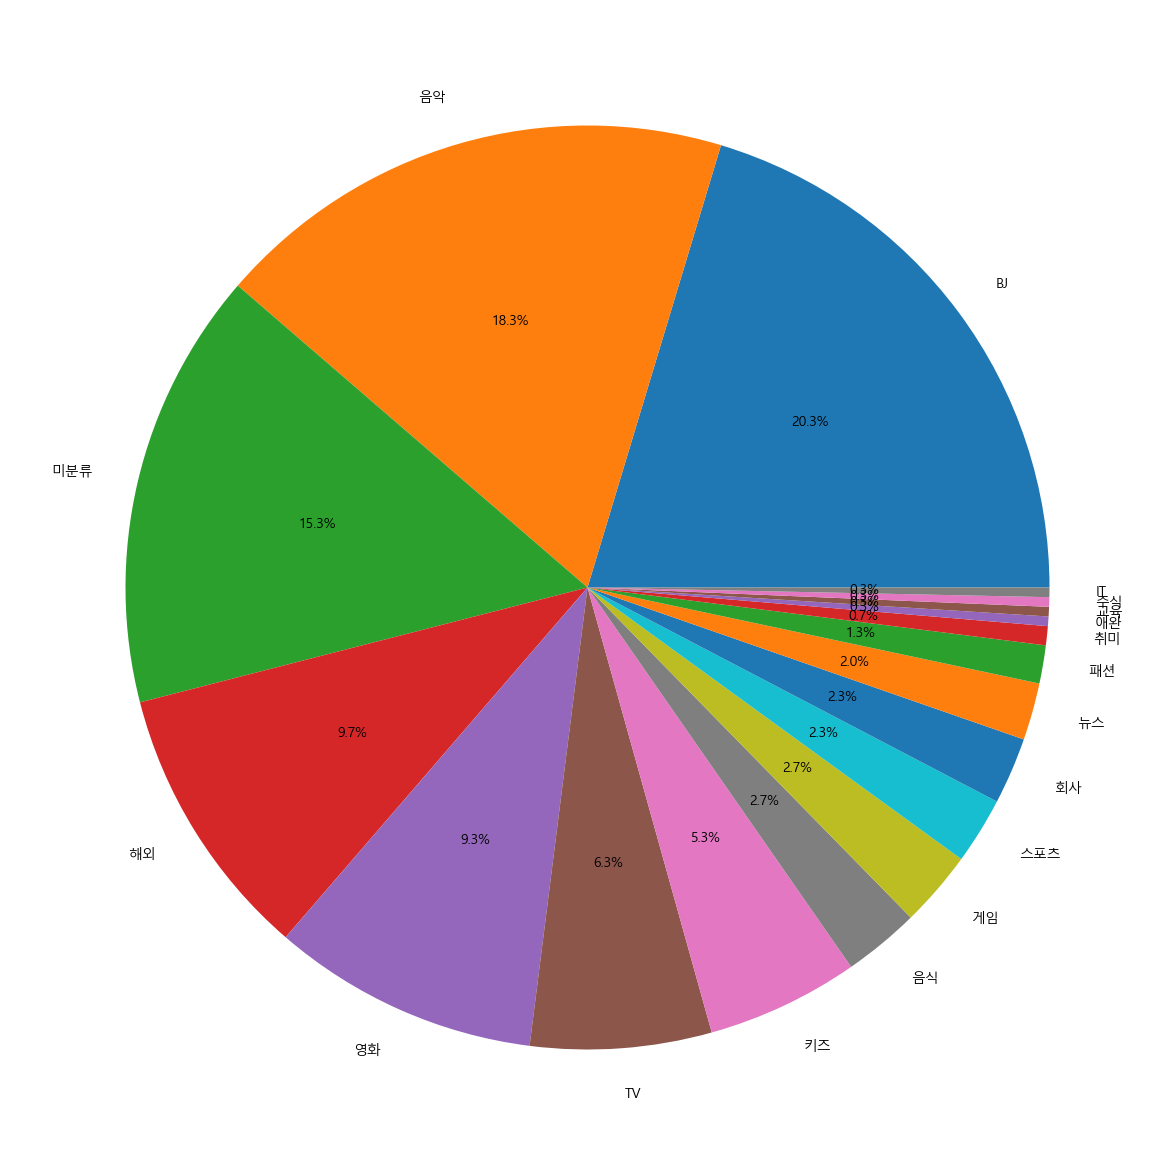

In [61]:
labels = df['category1'].unique()
counts = df['category1'].value_counts()
plt.figure(figsize=(15, 15))
plt.pie(counts, labels=labels, autopct='%1.1f%%')
plt.show()

### 분석
- 300위 안에 존재하는 카테고리 중 제일 많은 것은 'BJ'로 20.3%
- 두번째는 '음악'으로 15.2% (첫번째와 5.1% 차이)
- 미분류 카테고리가 15.3%로 세번째로 많음

## 구독자수/조회수/영상수 간 관계 분석
- 세 가지 인자 중 구독자수와 조회수가 관계가 있음

In [80]:
# 구독자수 상위 5개 데이터
df.sort_values(by='subscriber', ascending=False).head()

,rank,category1,category2,category3,channel,title,subscriber,view,video
0,1,BJ,인물,연예인,김프로KIMPRO,김프로 kimpro 김동준 김프로유투브 틱톡김프로 유투브김프로 김동준유튜브 유백합 ...,126000000,121896750000,3690
1,2,음악,댄스,가수,BLACKPINK,"""YG Entertainment"" YG 와이지 K-pop BLACKPINK 블랙핑크...",99400000,40772800000,641
2,3,음악,댄스,가수,BANGTANTV,BTS 방탄 방탄소년단 빅히트 BANGTAN RM Jin SUGA j-hope Ji...,81800000,26052130000,2947
3,4,음악,댄스,가수,HYBE LABELS,NaN,79200000,42682130000,2933
4,5,미분류,NaN,NaN,Justin Bieber,Justin Bieber kidrauhl one time biebs usher is...,76600000,36670360000,278


In [76]:
# 조회수 상위 5개 데이터
df.sort_values(by='view', ascending=False).head()

,rank,category1,category2,category3,channel,title,subscriber,view,video
0,1,BJ,인물,연예인,김프로KIMPRO,김프로 kimpro 김동준 김프로유투브 틱톡김프로 유투브김프로 김동준유튜브 유백합 ...,126000000,121896750000,3690
5,6,미분류,NaN,NaN,YRF,"""india movies"" ""indian music"" ""indian songs"" ""...",70700000,54055320000,4773
3,4,음악,댄스,가수,HYBE LABELS,NaN,79200000,42682130000,2933
1,2,음악,댄스,가수,BLACKPINK,"""YG Entertainment"" YG 와이지 K-pop BLACKPINK 블랙핑크...",99400000,40772800000,641
4,5,미분류,NaN,NaN,Justin Bieber,Justin Bieber kidrauhl one time biebs usher is...,76600000,36670360000,278


In [77]:
# 영상수 상위 5개 데이터
df.sort_values(by='video', ascending=False).head()

,rank,category1,category2,category3,channel,title,subscriber,view,video
146,146,뉴스,정치,사회,YTN,YTN LIVE 와이티엔 생방송 뉴스 news ytn실시간,5240000,18602730000,918696
228,229,뉴스,정치,사회,KBS News,"뉴스 kbs kbs뉴스 ""kbs 실시간"" korea news 9시뉴스 케비에스 ""k...",3500000,9777300000,416725
113,114,뉴스,정치,사회,MBCNEWS,"mbc ""mbc news"" ""mbc 뉴스"" 뉴스 엠비씨 뉴스데스크 뉴스투데이 정오뉴...",6070000,25869170000,352563
97,97,TV,방송,NaN,SBS 스브스 Drama,SBS Drama 드라마 금토드라마 SBS드라마,7010000,8486730000,352127
151,152,뉴스,정치,사회,SBS 뉴스,"SBSNEWS sbs sbs뉴스 korea KOREA ""korea news"" ""ko...",5100000,15881750000,312502


### 구독자수와 조회수

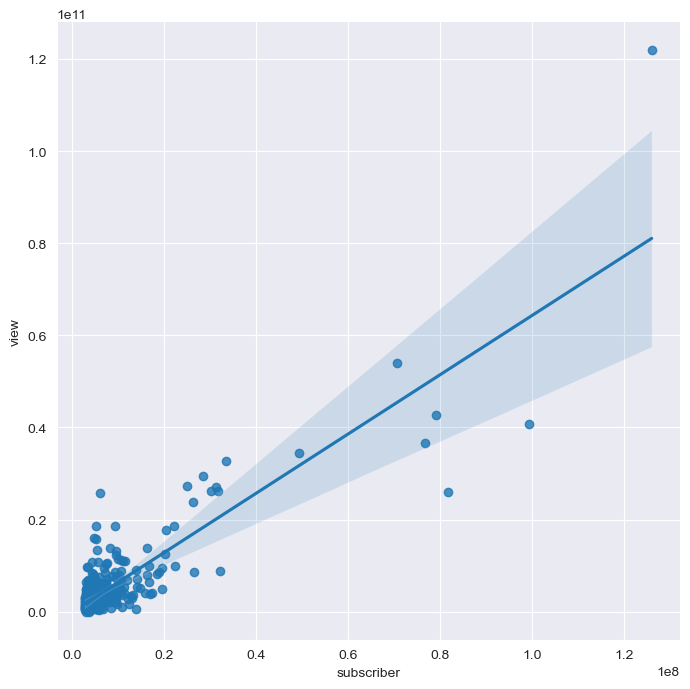

In [84]:
sns.set_style('darkgrid')
sns.lmplot(x='subscriber', y='view', data=df, height=7)
plt.show()

### 구독자수와 영상수의 관계

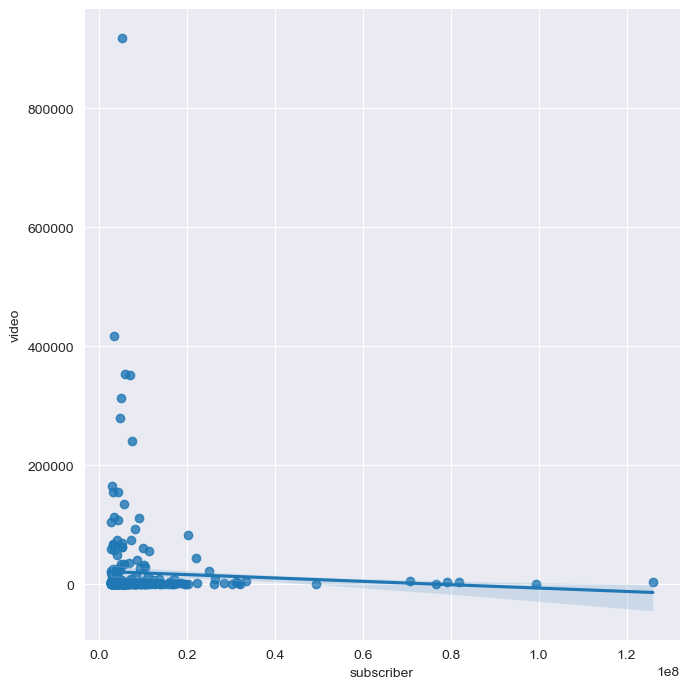

In [87]:
sns.set_style('darkgrid')
sns.lmplot(x='subscriber', y='video', data=df, height=7)
plt.show()

### 조회수와 영상수

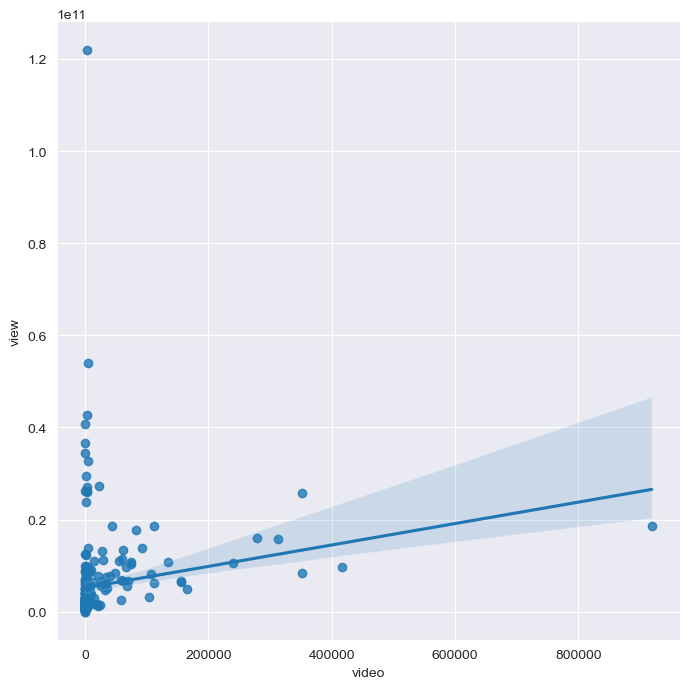

In [86]:
sns.set_style('darkgrid')
sns.lmplot(x='video', y='view', data=df, height=7)
plt.show()